Part of [iPyMacLern](http://ekaakurniawan.github.io/iPyMacLern/) project.

> Copyright (C) 2015 by Eka A. Kurniawan
> 
> eka.a.kurniawan(ta)gmail(tod)com
> 
> This program is free software: you can redistribute it and/or modify
> it under the terms of the GNU General Public License as published by
> the Free Software Foundation, either version 3 of the License, or
> (at your option) any later version.
> 
> This program is distributed in the hope that it will be useful,
> but WITHOUT ANY WARRANTY; without even the implied warranty of
> MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
> GNU General Public License for more details.
> 
> You should have received a copy of the GNU General Public License
> along with this program.  If not, see <http://www.gnu.org/licenses/>.

### Tested On

In [1]:
import sys
print("Python %d.%d.%d" % (sys.version_info.major, \
                           sys.version_info.minor, \
                           sys.version_info.micro))

Python 3.3.5


In [2]:
import numpy as np
print("NumPy %s" % np.__version__)

NumPy 1.8.0


In [3]:
import scipy
import scipy.io as sio
from scipy.optimize import fmin_cg
print("SciPy %s" % scipy.__version__)

SciPy 0.13.3


In [4]:
import matplotlib
import matplotlib.pyplot as plt
print("matplotlib %s" % matplotlib.__version__)

matplotlib 1.3.1


### Import Modules

In [5]:
import time

### Display Settings

In [6]:
# Display graph inline
%matplotlib inline

# Display graph in 'retina' format for Mac with retina display. Others, use PNG or SVG format.
%config InlineBackend.figure_format = 'retina'
#%config InlineBackend.figure_format = 'PNG'
#%config InlineBackend.figure_format = 'SVG'

# For displaying 3D graph
from mpl_toolkits.mplot3d import Axes3D

---

# Collaborative Filtering[1]

We are going to implement collaborative filtering algorithm for making movie recommendation based on previously rated movies by other users.

### Get and Plot Data

In [7]:
movies = sio.loadmat('ex8_movies.mat')
# Rating: 1 to 5 stars
# R_ij: rating of movie i by user j
R = movies['R']
# Rating flag
# Y_ij = 0: move i has not been rated by user j
# Y_ij = 1: move i has been rated by user j
Y = movies['Y']

Based on movie_ids.txt file, **Toy Story (1995)** movie is on the list no 1 or index 0.

$$index = list - 1$$

So the rating mean is as follow.

In [8]:
np.mean(Y[0, R[0] == 1])

3.8783185840707963

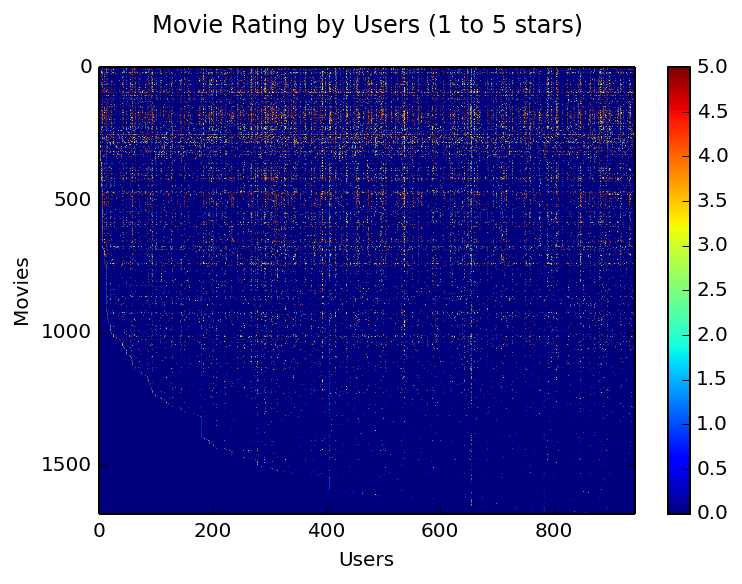

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)

imshow = ax.imshow(Y, aspect='auto')

plt.title('Movie Rating by Users (1 to 5 stars)\n', linespacing=1)
plt.xlabel('Users')
plt.ylabel('Movies')
plt.colorbar(imshow)

fig.show()

### Movie List

In [11]:
def load_movie_list(filename):
    movie_list = []
    with open(filename, 'r') as input_fh:
        for line in input_fh.readlines():
            space_idx = line.find(' ')
            if space_idx:
                movie_list.append(line[space_idx + 1:].strip())
    return movie_list

In [12]:
movie_list = load_movie_list('movie_ids.txt')

### Normalize Function

Normalize rating mean for each movie to 0.

In [13]:
def normalize_rating(Y, R):
    [m, n] = Y.shape
    Y_mean = np.zeros([m, 1])
    Y_norm = np.zeros(Y.shape)
    for i in range(m):
        Y_mean[i] = np.mean(Y[i, R[i] == 1])
    Y_norm = Y - Y_mean
    return Y_mean, Y_norm

In [14]:
Y_mean, Y_norm = normalize_rating(Y, R)

In [15]:
Y_mean

array([[ 3.87831858],
       [ 3.20610687],
       [ 3.03333333],
       ..., 
       [ 2.        ],
       [ 3.        ],
       [ 3.        ]])

In [16]:
Y_norm

array([[ 1.12168142,  0.12168142, -3.87831858, ...,  1.12168142,
        -3.87831858, -3.87831858],
       [-0.20610687, -3.20610687, -3.20610687, ..., -3.20610687,
        -3.20610687,  1.79389313],
       [ 0.96666667, -3.03333333, -3.03333333, ..., -3.03333333,
        -3.03333333, -3.03333333],
       ..., 
       [-2.        , -2.        , -2.        , ..., -2.        ,
        -2.        , -2.        ],
       [-3.        , -3.        , -3.        , ..., -3.        ,
        -3.        , -3.        ],
       [-3.        , -3.        , -3.        , ..., -3.        ,
        -3.        , -3.        ]])

### Cost and Gradient Functions

Collaborative filtering cost function:

$$J(x^{(1)},...,x^{(n_m)},\theta^{(1)},...,\theta^{(n_u)}) =
\frac{1}{2} \sum_{(i,j):r(i,j)=1} \left((\theta^{(j)})^T x^{(i)} - y^{(i,j)}\right)^2 + 
\frac{\lambda}{2} \sum_{i=1}^{n_m} \sum_{k=1}^{n} (x_k^{(i)})^2 +
\frac{\lambda}{2} \sum_{j=1}^{n_u} \sum_{k=1}^{n} (\theta_k^{(j)})^2$$

In [17]:
def compute_cost(X_Theta, args):
    Y, R, Lambda, n_m, n_u, n = args
    X_Theta = X_Theta.reshape([n_m + n_u, n])
    X = X_Theta[:n_m,:]
    Theta = X_Theta[n_m:,:]
    
    error = (np.dot(X, Theta.transpose()) - Y) * R
    J = (np.sum(error ** 2) / 2) + \
        ((Lambda * np.sum(Theta ** 2)) / 2) + \
        ((Lambda * np.sum(X ** 2)) / 2)
    return J

In [18]:
def compute_cost_wrapper(X_Theta):
    return compute_cost(X_Theta, args)

Collaborative filtering gradient function:

$$x_k^{(i)} := x_k^{(i)} - \alpha \left(\sum_{j:r(i,j)=1} \left((\theta^{(j)})^T x^{(i)} - y^{(i,j)}\right) \theta_k^{(i)} + \lambda x_k^{(i)} \right)$$

$$\theta_k^{(j)} := \theta_k^{(j)} - \alpha \left(\sum_{i:r(i,j)=1} \left((\theta^{(j)})^T x^{(i)} - y^{(i,j)}\right) x_k^{(i)} + \lambda \theta_k^{(j)} \right)$$

In [19]:
def compute_grad(X_Theta, args):
    Y, R, Lambda, n_m, n_u, n = args
    X_Theta = X_Theta.reshape([n_m + n_u, n])
    X = X_Theta[:n_m,:]
    Theta = X_Theta[n_m:,:]
    
    error = (np.dot(X, Theta.transpose()) - Y) * R
    X_grad = np.dot(error, Theta) + (Lambda * X)
    Theta_grad = np.dot(error.transpose(), X) + (Lambda * Theta)
    return np.vstack([X_grad, Theta_grad]).flatten()

In [20]:
def compute_grad_wrapper(X_Theta):
    return compute_grad(X_Theta, args)

In [21]:
dummy_movies = sio.loadmat('ex8_movieParams.mat')

dummy_num_users = 4
dummy_num_movies = 5
dummy_num_features = 3

dummy_X = dummy_movies['X'][:dummy_num_movies, :dummy_num_features]
dummy_Theta = dummy_movies['Theta'][:dummy_num_users, :dummy_num_features]
dummy_Y = Y[:dummy_num_movies, :dummy_num_users]
dummy_R = R[:dummy_num_movies, :dummy_num_users]

In [22]:
Lambda = 1.5
X_Theta = np.vstack([dummy_X, dummy_Theta]).flatten()
args = np.asarray((dummy_Y, dummy_R, Lambda, dummy_num_movies, dummy_num_users, dummy_num_features))
J = compute_cost(X_Theta, args)

In [23]:
J

31.344056244274217

In [24]:
Lambda = 1.5
X_Theta = np.vstack([dummy_X, dummy_Theta])
args = np.asarray((dummy_Y, dummy_R, Lambda, dummy_num_movies, dummy_num_users, dummy_num_features))
grad = compute_grad(X_Theta, args)

In [25]:
grad

array([ -0.95596339,   6.97535514,  -0.10861109,   0.60308088,
         2.77421145,   0.25839822,   0.12985616,   4.0898522 ,
        -0.89247334,   0.29684395,   1.06300933,   0.66738144,
         0.60252677,   4.90185327,  -0.19747928, -10.13985478,
         2.10136256,  -6.76563628,  -2.29347024,   0.48244098,
        -2.99791422,  -0.64787484,  -0.71820673,   1.27006666,
         1.09289758,  -0.40784086,   0.49026541])

### Rate Movies

In [26]:
# Get total movies (n_m) and total users (n_u)
n_m, n_u = Y.shape

In [27]:
my_ratings = np.zeros([n_m, 1])

my_ratings[0]   = 4
my_ratings[97]  = 2
my_ratings[6]   = 3
my_ratings[11]  = 5
my_ratings[53]  = 4
my_ratings[63]  = 5
my_ratings[65]  = 3
my_ratings[68]  = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

In [28]:
for i, rating in enumerate(my_ratings):
    if rating:
        print('Rated %5s for %s' % ('*' * int(rating), movie_list[i]))

Rated  **** for Toy Story (1995)
Rated   *** for Twelve Monkeys (1995)
Rated ***** for Usual Suspects, The (1995)
Rated  **** for Outbreak (1995)
Rated ***** for Shawshank Redemption, The (1994)
Rated   *** for While You Were Sleeping (1995)
Rated ***** for Forrest Gump (1994)
Rated    ** for Silence of the Lambs, The (1991)
Rated  **** for Alien (1979)
Rated ***** for Die Hard 2 (1990)
Rated ***** for Sphere (1998)


In [29]:
my_Y = np.hstack([my_ratings, Y])
my_R = np.hstack([(my_ratings != 0).astype(int), R])

# Normalize
my_Y_mean, my_Y_norm = normalize_rating(my_Y, my_R)

### Learn Rating

In [30]:
# Get total movies (n_m) and total users (n_u)
n_m, n_u = my_Y.shape

# Total parameters
n = 100

# Initialize random parameters X and Theta
X_init = np.random.rand(n_m, n)
Theta_init = np.random.rand(n_u, n)
X_Theta_init = np.vstack([X_init, Theta_init]).flatten()

# Regularization
Lambda = 1.5

# Arguments
args = np.asarray((my_Y_norm, my_R, Lambda, n_m, n_u, n))

In [31]:
tic = time.time()
X_Theta_result = fmin_cg(compute_cost_wrapper, X_Theta_init, fprime=compute_grad_wrapper)
toc = time.time()
print('Runtime: %s seconds' % int(toc - tic))

Optimization terminated successfully.
         Current function value: 7669.494642
         Iterations: 30997
         Function evaluations: 46509
         Gradient evaluations: 46509
Runtime: 5865 seconds


In [32]:
X_Theta_init

array([ 0.33978896,  0.89135159,  0.57271891, ...,  0.88639447,
        0.65747604,  0.86685001])

In [33]:
X_Theta_result = X_Theta_result.reshape([n_m + n_u, n])
X_result = X_Theta_result[:n_m,:]
Theta_result = X_Theta_result[n_m:,:]

In [34]:
X_result

array([[  2.41134386e-01,   4.16605580e-01,  -2.82517486e-01, ...,
          4.17844390e-01,  -1.36868644e-01,  -6.30193175e-01],
       [  2.48698201e-01,   5.65252518e-03,   1.51324513e-01, ...,
         -1.75062290e-01,   1.75681428e-01,   4.48542615e-01],
       [  8.52895286e-02,   6.13161351e-02,   2.65269003e-01, ...,
          4.49911592e-02,   7.49382583e-02,   1.48852701e-01],
       ..., 
       [  1.71304984e-85,  -2.90477555e-86,   5.96873773e-86, ...,
          6.16536692e-86,   2.54496232e-85,  -8.74247439e-86],
       [  2.93461393e-84,  -1.05429474e-84,  -2.93150891e-84, ...,
          4.01963936e-84,  -1.40389972e-84,  -6.49860358e-84],
       [ -1.64402366e-86,   4.55035643e-86,   1.12674841e-85, ...,
          7.13550591e-87,   9.62853087e-86,  -1.54038254e-86]])

In [35]:
Theta_result

array([[-0.13135235,  0.07522326, -0.08265132, ...,  0.09450901,
        -0.0852744 ,  0.18545998],
       [-0.61978241, -0.50740478, -0.35146157, ...,  0.13980794,
        -0.27407782, -0.13645226],
       [ 0.17489829,  0.05794451,  0.05759873, ...,  0.20169707,
        -0.05028262, -0.29324708],
       ..., 
       [-0.20312246,  0.13998442, -0.20895302, ...,  0.02036318,
         0.06342229, -0.07521698],
       [ 0.21877971, -0.03060997,  0.2034301 , ...,  0.08173766,
         0.01236178, -0.08394755],
       [ 0.43557182, -0.07410227,  0.52823772, ..., -0.29443146,
         0.20379433,  0.66521867]])

In [36]:
# Prediction
p = np.dot(X_result, Theta_result.transpose()) + Y_mean
p = np.rint(((p - np.min(p)) / (np.abs(np.min(p)) + np.abs(np.max(p)))) * 4) + 1
my_predictions = p[:,1].reshape(p.shape[0],1)
sorted_my_predictions = np.argsort(my_predictions, axis=0)[::-1]

In [37]:
# Display top ten recommendation
for i in sorted_my_predictions[:10]:
    print('Rated %5s for %s' % (('*' * int(my_predictions[i])), movie_list[i]))

Rated  **** for Toy Story (1995)
Rated  **** for Back to the Future (1985)
Rated  **** for Princess Bride, The (1987)
Rated  **** for Raiders of the Lost Ark (1981)
Rated  **** for Aiqing wansui (1994)
Rated  **** for Brazil (1985)
Rated  **** for Aliens (1986)
Rated  **** for Good, The Bad and The Ugly, The (1966)
Rated  **** for 12 Angry Men (1957)
Rated  **** for To Kill a Mockingbird (1962)


---

# Testing with Small Sample

In [38]:
Y = np.asarray([[5, 5, 0, 0],
                [5, 0, 0, 0],
                [0, 4, 0, 0],
                [0, 0, 5, 4],
                [0, 0, 5, 0]])

R = np.asarray([[1, 1, 1, 1],
                [1, 0, 0, 1],
                [0, 1, 1, 0],
                [1, 1, 1, 1],
                [1, 1, 1, 0]])

movie_list = ['Love at Last',
              'Romance Forever',
              'Cute Puppies of Love',
              'Nonstop Car Chases',
              'Swords vs Karate']

In [39]:
def normalize_rating(Y, R):
    [m, n] = Y.shape
    Y_mean = np.zeros([m, 1])
    Y_norm = np.zeros(Y.shape)
    for i in range(m):
        Y_mean[i] = np.mean(Y[i, R[i] == 1])
    Y_norm = Y - Y_mean
    return Y_mean, Y_norm

In [40]:
# Normalize
Y_mean, Y_norm = normalize_rating(Y, R)

# Get total movies (n_m) and total users (n_u)
n_m, n_u = Y.shape

# Total parameters
n = 100

# Initialize random parameters X and Theta
X_init = np.random.rand(n_m, n)
Theta_init = np.random.rand(n_u, n)
X_Theta_init = np.vstack([X_init, Theta_init]).flatten()

# Regularization
Lambda = 1.5

# Arguments
args = np.asarray((Y_norm, R, Lambda, n_m, n_u, n))

In [41]:
X_Theta_result = fmin_cg(compute_cost_wrapper, X_Theta_init, fprime=compute_grad_wrapper)

Optimization terminated successfully.
         Current function value: 14.655919
         Iterations: 57
         Function evaluations: 94
         Gradient evaluations: 94


In [42]:
X_Theta_result = X_Theta_result.reshape([n_m + n_u, n])
X_result = X_Theta_result[:n_m,:]
Theta_result = X_Theta_result[n_m:,:]

In [43]:
# Prediction
p = np.dot(X_result, Theta_result.transpose()) + Y_mean
p = np.rint(((p - np.min(p)) / (np.abs(np.min(p)) + np.abs(np.max(p)))) * 5)

In [44]:
p

array([[ 5.,  5.,  0.,  1.],
       [ 5.,  5.,  0.,  1.],
       [ 4.,  4.,  0.,  1.],
       [ 1.,  1.,  5.,  4.],
       [ 0.,  0.,  4.,  4.]])

---

# References

1. Andrew Y. Ng, 2015. _Machine Learning_. Week 9: Recommender Systems. Stanford. Coursera. https://www.coursera.org/learn/machine-learning